In [1]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
from distributed import LocalCluster, Client, progress
import dask.dataframe as dd
import pandas as pd

client =  Client(n_workers=31,  threads_per_worker=1, processes=True, memory_limit='4 GiB') 

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44791 instead
  warnings.warn(


In [2]:

full_load_path = f"/depot/cms/users/yun79/results/stage1/test_full_noRochester/2018/f1_0/dy_M-100To200/*/*.parquet"
df_dyIncl = dak.from_parquet(full_load_path)


full_load_path = f"/depot/cms/users/yun79/results/stage1/bigV2_AddDyVbfFilterGjjIsHardProcess_31May2024/2018/f1_0/dy_VBF_filter/*/*.parquet"
df_dyVBFfilter = dak.from_parquet(full_load_path)


variables = ["dimuon_mass","mu1_pt","mu1_eta",
             "jet1_pt", "jet1_eta", 
            ]
fields2load = variables + ["weights", "fraction", "h_sidebands", "h_peak", "z_peak", "vbf_cut","nBtagLoose", "nBtagMedium","gjj_mass", "jj_mass"]
# load in the features once to save runtime
df_dyIncl = df_dyIncl[fields2load].compute()
df_dyVBFfilter = df_dyVBFfilter[fields2load].compute()

In [3]:
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [110, 150, 50],
}

In [4]:

# calculate the base weights

region = df_dyIncl.h_sidebands | df_dyIncl.h_peak
region =ak.fill_none(region, value = False)
btag_cut =(df_dyIncl.nBtagLoose >= 2) | (df_dyIncl.nBtagMedium >= 1)
btag_cut =ak.fill_none(btag_cut, value = False)
vbf_cut = df_dyIncl.vbf_cut
vbf_cut_dyIncl =ak.fill_none(vbf_cut, value = False)
weights_dyIncl = (df_dyIncl["weights"]
               # * vbf_cut
              # * ~btag_cut
               * region
              )



region = df_dyVBFfilter.h_sidebands | df_dyVBFfilter.h_peak
region =ak.fill_none(region, value = False)
btag_cut =(df_dyVBFfilter.nBtagLoose >= 2) | (df_dyVBFfilter.nBtagMedium >= 1)
btag_cut =ak.fill_none(btag_cut, value = False)
vbf_cut = df_dyVBFfilter.vbf_cut
vbf_cut_dyVBFfilter =ak.fill_none(vbf_cut, value = False)
weights_dyVBFfilter = (df_dyVBFfilter["weights"]
               # * vbf_cut
              # * ~btag_cut
               * region
              )





In [ ]:
# """
# Weight plot
# """
# binning = np.linspace(*[-0.2, 0.2, 80])
# val_dyIncl = weights_dyIncl[weights_dyIncl!=0]
# val_dyVBFfilter = weights_dyVBFfilter[weights_dyVBFfilter!=0]
# hist_wgt_dyIncl, edges= np.histogram(val_dyIncl, bins=binning, density=True)
# hist_wgt_dyVBFfilter, _= np.histogram(val_dyVBFfilter, bins=binning, density=True)
# plt.stairs(hist_wgt_dyIncl, edges, label = "Normal DY")
# plt.stairs(hist_wgt_dyVBFfilter, edges, label = "VBF filter")
# plt.legend(loc="upper right")
# plt.title("weights")
# plt.savefig(f"./quick_plots/weights.pdf")
# plt.show()

In [5]:
# work on normal plot
normal_plot_wgt = weights_dyIncl

# work on VBF filter plot
# work on inclusive DY
vbf_filter = ak.fill_none((df_dyIncl.gjj_mass > 350), value=False)
filter_plot_dyIncl_wgt = (~vbf_filter) * weights_dyIncl

# work on VBF filtered DY
vbf_filter = ak.fill_none((df_dyVBFfilter.gjj_mass > 350), value=False)
filter_plot_dyVBFfilter_wgt = (vbf_filter) * weights_dyVBFfilter



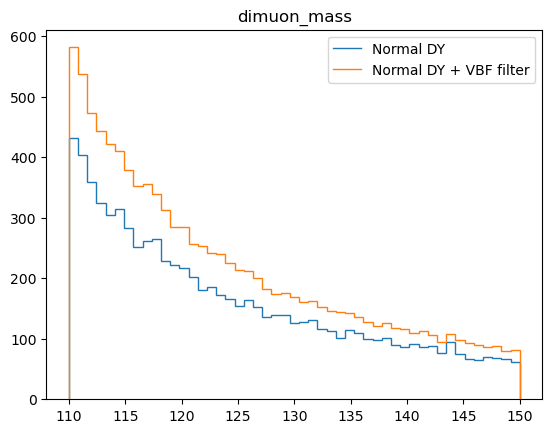

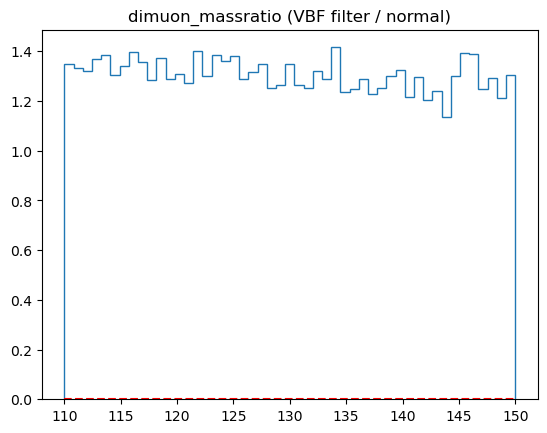

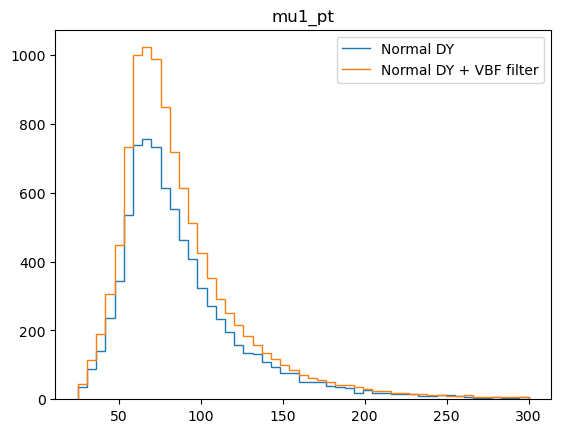

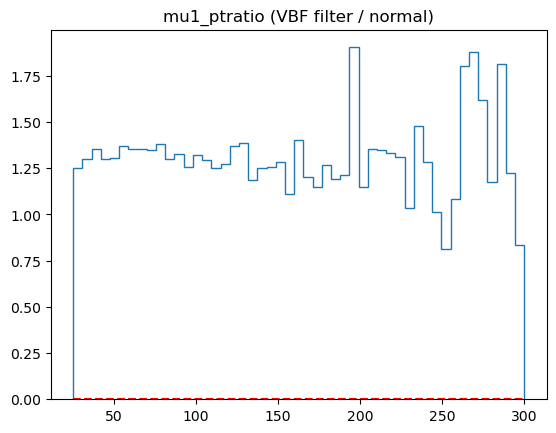

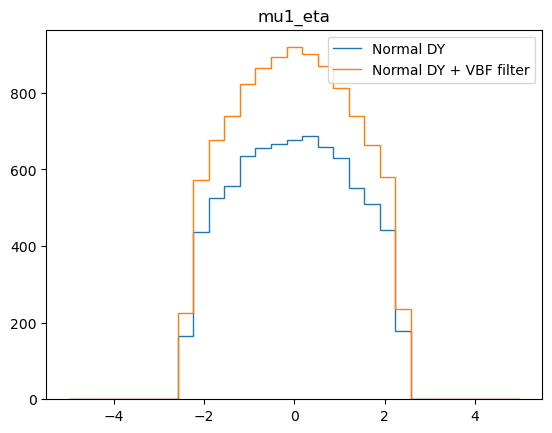

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


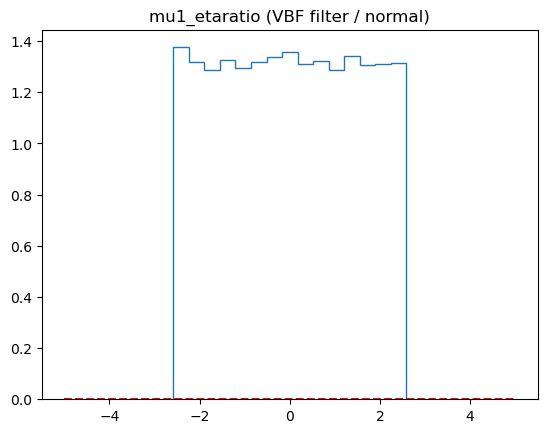

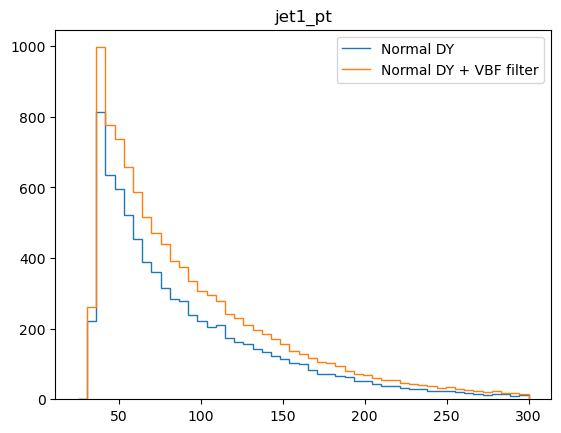

/depot/cms/kernels/coffea2024/lib/python3.10/site-packages/awkward/_nplikes/array_module.py:246: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


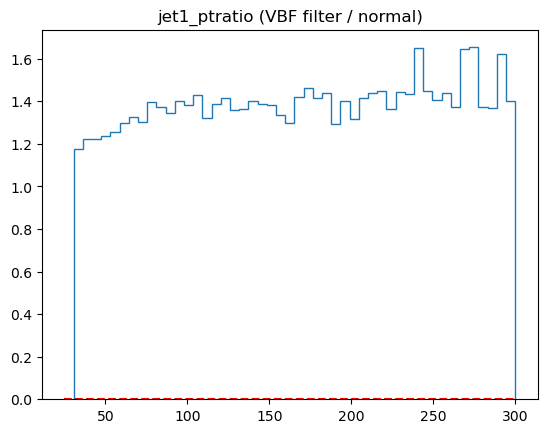

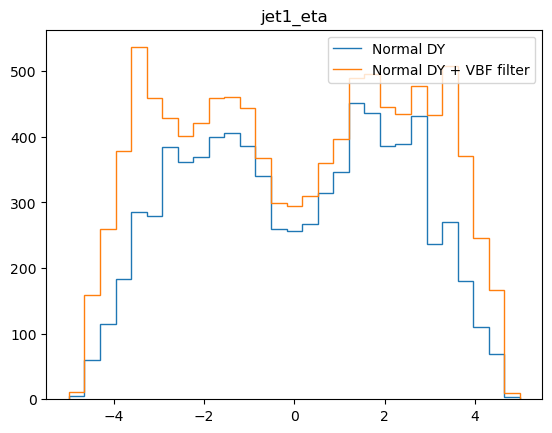

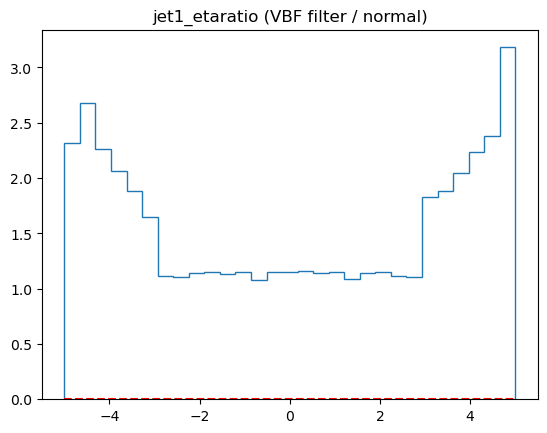

In [13]:

for var in variables:
    kin = var.split("_")[-1]
    binning = np.linspace(*binning_map[kin])

    hist_normal, edges= np.histogram(df_dyIncl[var], bins=binning ,weights=normal_plot_wgt)

    hist_VbfFilter_dyIncl, _= np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_VbfFilter = hist_VbfFilter_dyIncl + hist_VbfFilter_dyVbfFilter

    
    plt.stairs(hist_normal, edges, label = "Normal DY")
    plt.stairs(hist_VbfFilter, edges, label = "Normal DY + VBF filter")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.savefig(f"./quick_plots/{var}.pdf")
    plt.show()
    plt.stairs((hist_VbfFilter/hist_normal), edges)
    plt.title(var+"ratio (VBF filter / normal)")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.savefig(f"./quick_plots/{var}_ratio.pdf")
    plt.show()


In [16]:
print(np.max(df_dyIncl["gjj_mass"]))
print(np.min(df_dyIncl["gjj_mass"]))
print(np.max(df_dyIncl["jj_mass"]))
print(np.min(df_dyIncl["jj_mass"]))

7622.5684
4.635756
6366.456
12.080204


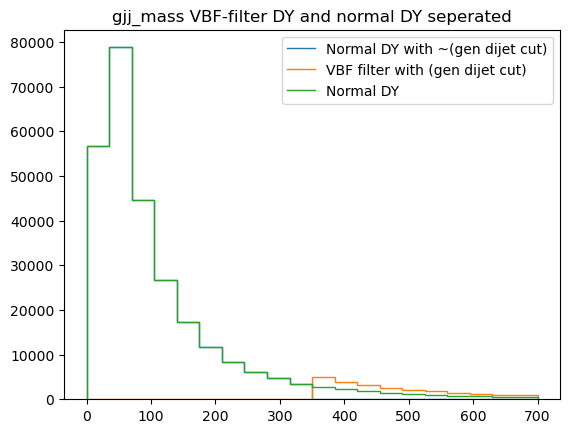

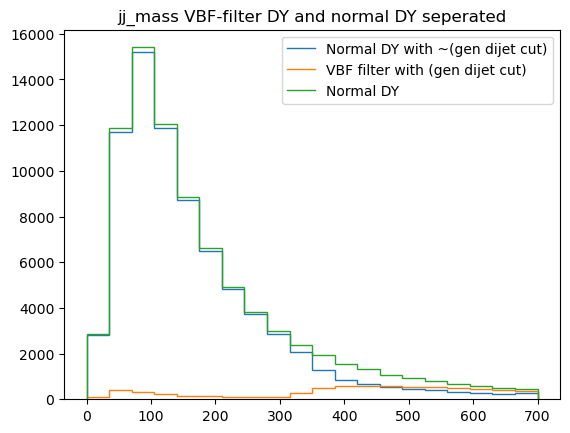

<Figure size 640x480 with 0 Axes>

In [87]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}
for var in ["gjj_mass", "jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [34.4, 32, 29.9, 28, 26.3, 24.7, 23.4, 22, 20.8, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 6.77, 6.44, 6.15, 5.89, 5.62, 5.37, 5.16, 4.96]
err_dyIncl: [34.4, 32, 29.9, 28, 26.3, 24.7, 23.4, ..., 15.5, 14.9, 14.2, 13.6, 13, 12.4]


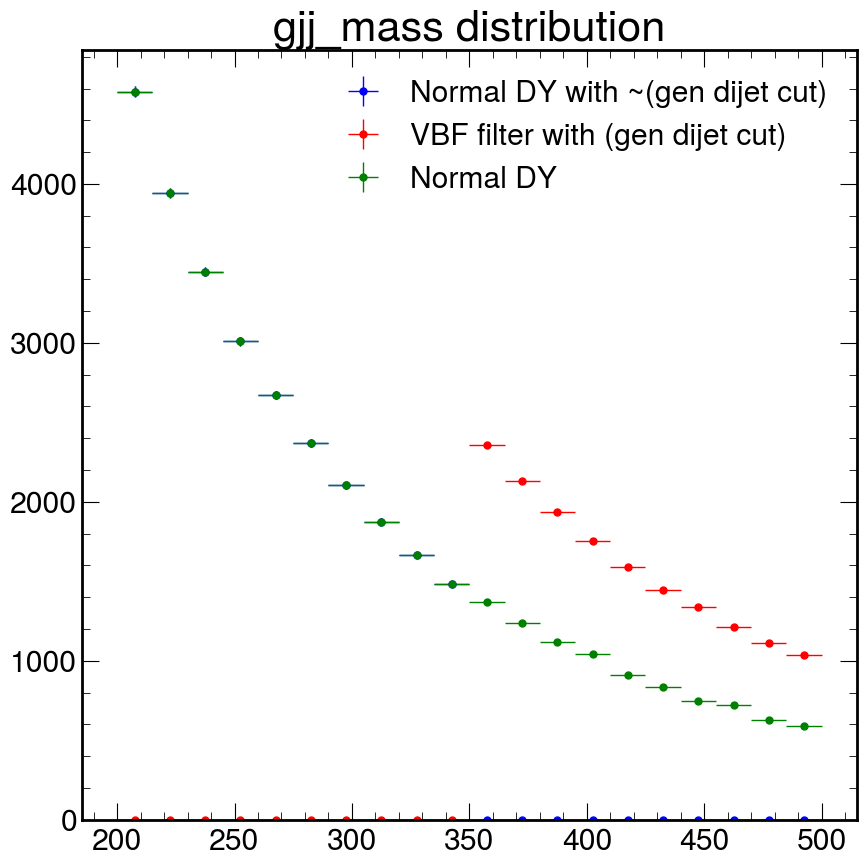

<Figure size 1000x1000 with 0 Axes>

In [6]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 500, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}


for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*normal_plot_wgt)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution")
    plt.savefig(f"./quick_plots/{var}_separate_normal.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [34.4, 32, 29.9, 28, 26.3, 24.7, 23.4, 22, 20.8, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 3.83, 3.65, 3.48, 3.33, 3.18, 3.04, 2.92, 2.81]
err_dyIncl: [34.4, 32, 29.9, 28, 26.3, 24.7, 23.4, ..., 15.5, 14.9, 14.2, 13.6, 13, 12.4]


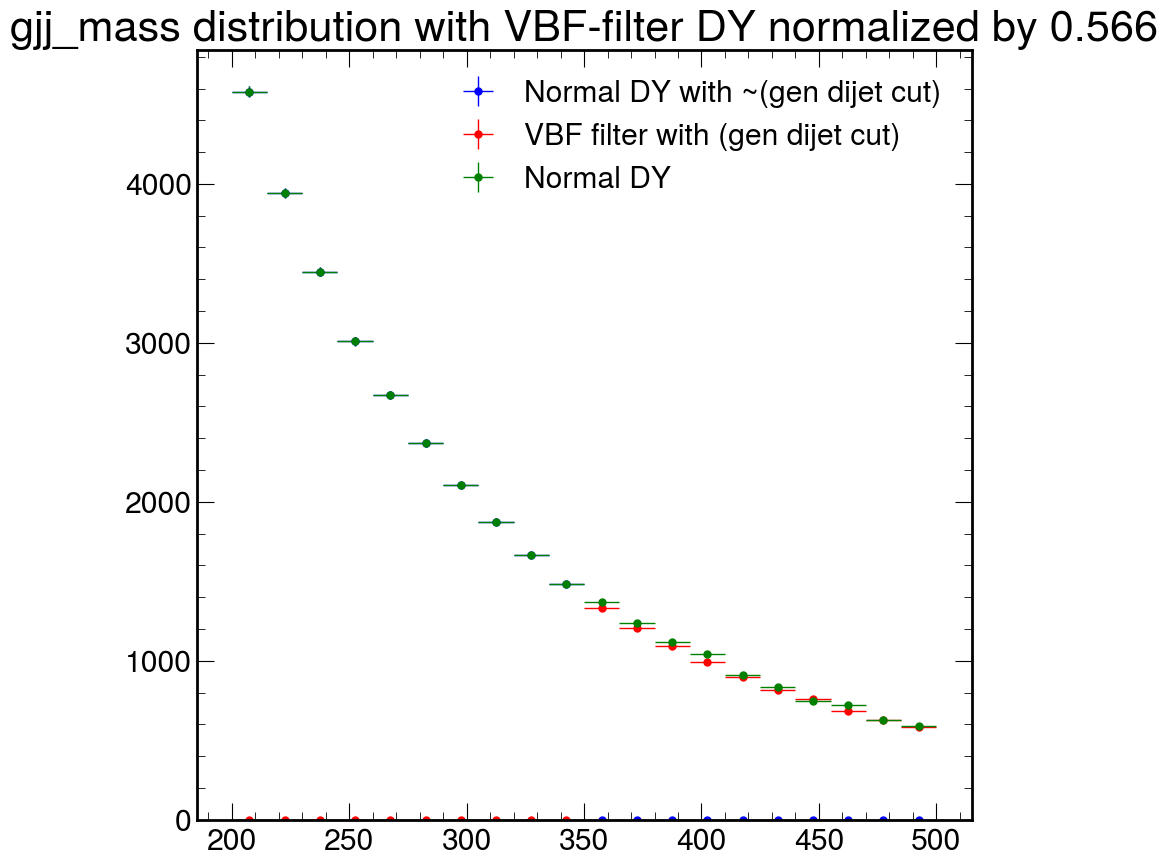

<Figure size 1000x1000 with 0 Axes>

In [7]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 500, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 500, 21],
}

normalization_factor = 0.5655718250957196
# normalization_factor= 1

for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*filter_plot_dyIncl_wgt)

    filter_plot_dyVBFfilter_wgt_final = normalization_factor* filter_plot_dyVBFfilter_wgt
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*normal_plot_wgt)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper right")
    plt.title(f"{var} distribution with VBF-filter DY normalized by {normalization_factor:.3g}")
    plt.savefig(f"./quick_plots/{var}_NormFacCheck.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [5.71, 5.12, 5.12, 5.01, 5.4, 6.31, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 4.28, 4.34, ..., 3.44, 3.26, 3.07, 2.92, 2.76, 2.61, 2.5]
err_dyIncl: [5.71, 5.12, 5.12, 5.01, 5.4, 6.31, ..., 8.35, 7.83, 7.42, 6.82, 6.7, 6.45]


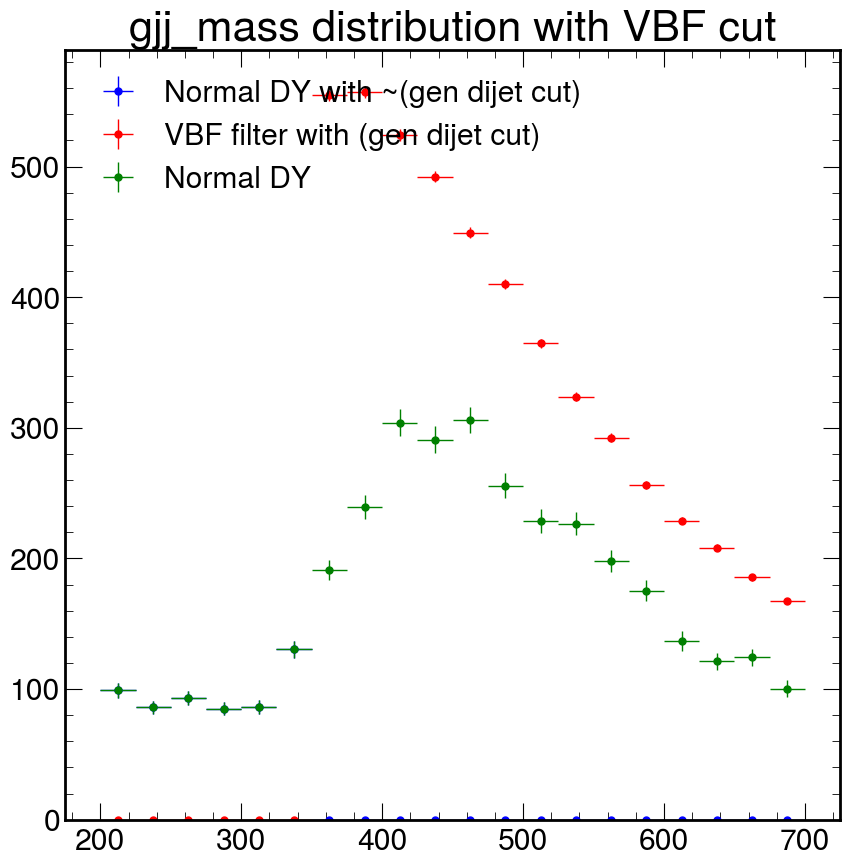

<Figure size 1000x1000 with 0 Axes>

In [8]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 700, 21],
}


for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    filter_plot_dyIncl_wgt_final = filter_plot_dyIncl_wgt*vbf_cut_dyIncl
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final*filter_plot_dyIncl_wgt_final)

    filter_plot_dyVBFfilter_wgt_final = filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    
    normal_plot_wgt_final = normal_plot_wgt*vbf_cut_dyIncl
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final*normal_plot_wgt_final)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper left")
    plt.title(f"{var} distribution with VBF cut")
    plt.savefig(f"./quick_plots/{var}_separate_w_VBFcut.pdf")
    plt.show()
    plt.clf()

err_VbfFilter_dyIncl: [5.36, 4.79, 4.79, 4.69, 5.07, 6.02, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0]
err_VbfFilter_dyVbfFilter: [0, 0, 0, 0, 0, 0, 2.21, 2.23, ..., 1.76, 1.67, 1.57, 1.5, 1.42, 1.34, 1.28]
err_dyIncl: [5.36, 4.79, 4.79, 4.69, 5.07, 6.02, 7.53, ..., 8, 7.45, 7.08, 6.52, 6.37, 6.17]


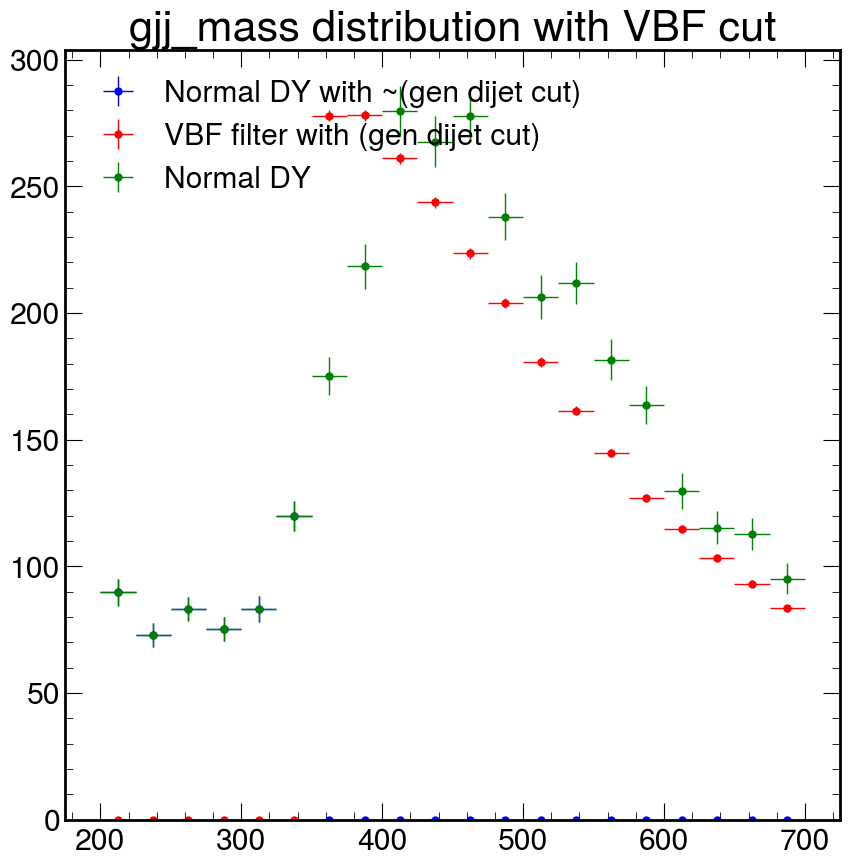

<Figure size 1000x1000 with 0 Axes>

In [126]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
import mplhep as hep
plt.style.use(hep.style.CMS)
binning_map = {
    "gjj_mass" : [200, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [200, 700, 21],
}

normalization_factor = 0.5374928504343454


for var in ["gjj_mass"]:
    fig, ax_main = plt.subplots()
    binning = np.linspace(*binning_map[var])
    filter_plot_dyIncl_wgt_final = filter_plot_dyIncl_wgt*vbf_cut_dyIncl
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final)
    hist_VbfFilter_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt_final*filter_plot_dyIncl_wgt_final)

    filter_plot_dyVBFfilter_wgt_final = filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter*normalization_factor
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final)
    hist_VbfFilter_dyVbfFilter_w2, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt_final*filter_plot_dyVBFfilter_wgt_final)
    
    normal_plot_wgt_final = normal_plot_wgt*vbf_cut_dyIncl
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final)
    hist_dyIncl_w2, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt_final*normal_plot_wgt_final)

    err_VbfFilter_dyIncl = np.sqrt(hist_VbfFilter_dyIncl_w2)
    print(f"err_VbfFilter_dyIncl: {err_VbfFilter_dyIncl}")
    hep.histplot(hist_VbfFilter_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY with ~(gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyIncl,
        # sort='label_r', 
        color = "blue",
        ax=ax_main
    )
    err_VbfFilter_dyVbfFilter = np.sqrt(hist_VbfFilter_dyVbfFilter_w2)
    print(f"err_VbfFilter_dyVbfFilter: {err_VbfFilter_dyVbfFilter}")
    hep.histplot(hist_VbfFilter_dyVbfFilter, bins=binning, 
         histtype='errorbar', 
        label="VBF filter with (gen dijet cut)", 
         xerr=True, 
         yerr=err_VbfFilter_dyVbfFilter,
        # sort='label_r', 
        color = "red",
        ax=ax_main
    )
    err_dyIncl = np.sqrt(hist_dyIncl_w2)
    print(f"err_dyIncl: {err_dyIncl}")
    hep.histplot(hist_dyIncl, bins=binning, 
         histtype='errorbar', 
        label="Normal DY", 
         xerr=True, 
         yerr=err_dyIncl,
        # sort='label_r', 
        color = "green",
        ax=ax_main
    )
    plt.legend(loc="upper left")
    plt.title(f"{var} distribution with VBF cut")
    plt.savefig(f"./quick_plots/{var}_separate_w_VBFcut_NormFacCheck.pdf")
    plt.show()
    plt.clf()

In [118]:
print(hist_VbfFilter_dyVbfFilter[10:])
print(hist_dyIncl[10:])
print(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:])
print(np.mean(hist_dyIncl[10:]/hist_VbfFilter_dyVbfFilter[10:]))

[313, 309, 311, 299, 288, 272, 268, 250, 233, 224]
[98.3, 117, 129, 164, 165, 167, 154, 169, 149, 145]
[0.314, 0.379, 0.414, 0.549, 0.572, 0.614, 0.573, 0.674, 0.637, 0.648]
0.5374928504343454


In [123]:
np.linspace(*[200, 700, 21])

array([200., 225., 250., 275., 300., 325., 350., 375., 400., 425., 450.,
       475., 500., 525., 550., 575., 600., 625., 650., 675., 700.])

In [ ]:
"""
dijet mass plot of vbf filtered DY vs normal DY with no vbf fitlering
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass", "jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=weights_dyIncl)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=weights_dyVBFfilter)
    # hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    # plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()



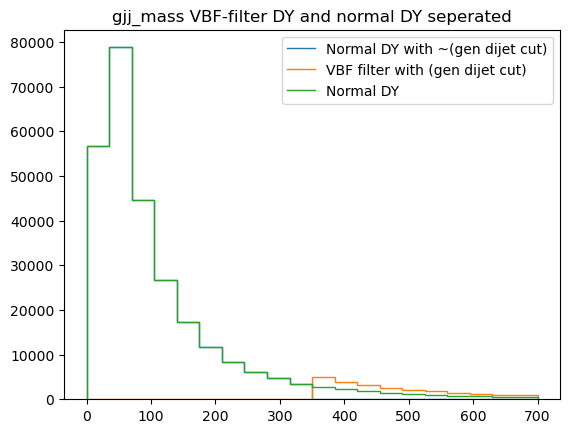

<Figure size 640x480 with 0 Axes>

In [70]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    # plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} VBF-filter DY and normal DY seperated")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

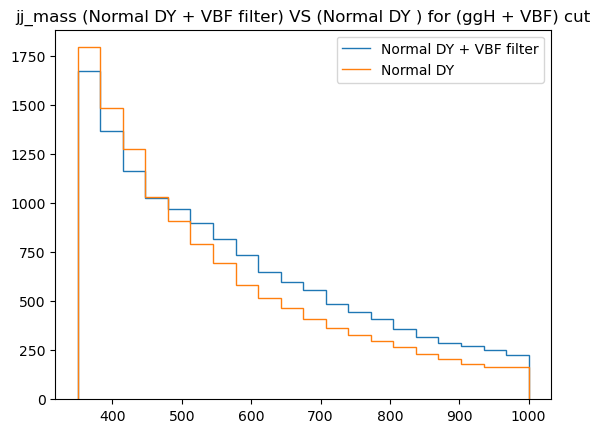

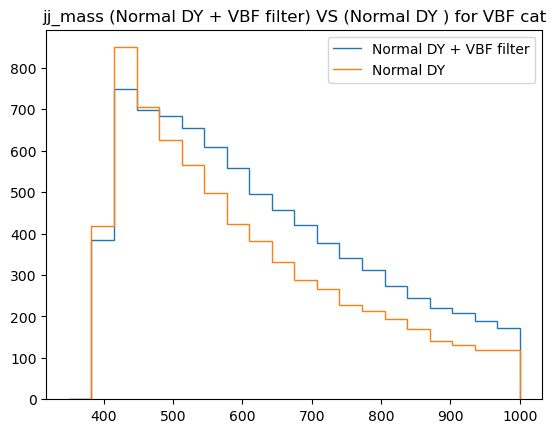

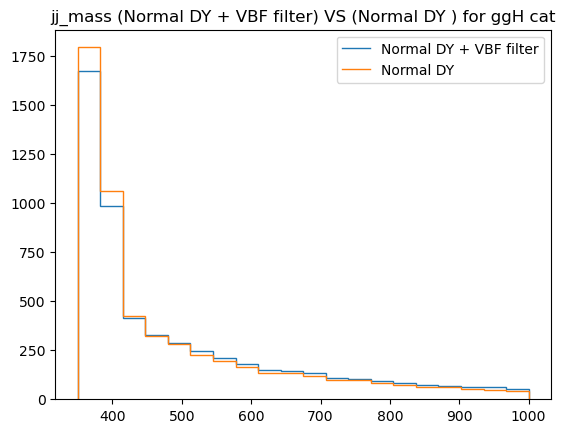

<Figure size 640x480 with 0 Axes>

In [86]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [350, 1000, 21],
}


for var in ["jj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for (ggH + VBF) cut")
    plt.show()
    plt.clf()
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*vbf_cut_dyIncl)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*vbf_cut_dyVBFfilter)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*vbf_cut_dyIncl)
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for VBF cat")
    plt.show()
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt*(~vbf_cut_dyIncl))
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt*(~vbf_cut_dyVBFfilter))
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt*(~vbf_cut_dyIncl))
    plt.stairs((hist_VbfFilter_dyIncl+hist_VbfFilter_dyVbfFilter), edges, label = "Normal DY + VBF filter")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.legend(loc="upper right")
    plt.title(f"{var} (Normal DY + VBF filter) VS (Normal DY ) for ggH cat")
    plt.show()
    plt.clf()

ratio: [3.11, 2.67, 2.05, 1.75, 1.71, 1.71, ..., 1.55, 1.57, 1.76, 1.51, 1.68, 1.6]
ratio/1.5: [2.07, 1.78, 1.36, 1.17, 1.14, 1.14, ..., 1.03, 1.05, 1.17, 1.01, 1.12, 1.07]


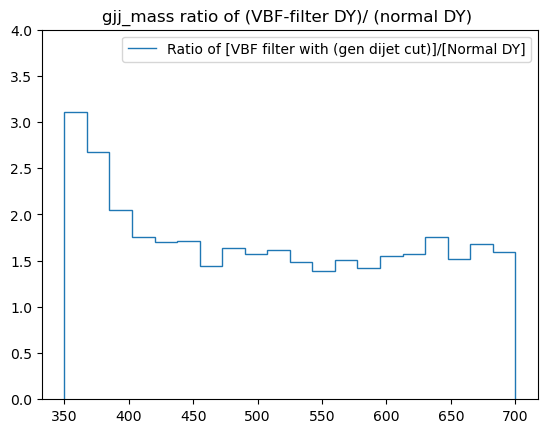

<Figure size 640x480 with 0 Axes>

In [53]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [350, 700, 21],
    "jj_mass" : [0, 700, 21],
}


for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    # hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, edges= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    ratio = hist_VbfFilter_dyVbfFilter/hist_dyIncl
    print(f"ratio: {ratio}")
    print(f"ratio/1.5: {ratio/1.5}")
    plt.stairs(ratio, edges, label = "Ratio of [VBF filter with (gen dijet cut)]/[Normal DY]")
    plt.ylim(0, 4)
    plt.legend(loc="upper right")
    plt.title(f"{var} ratio of (VBF-filter DY)/ (normal DY) ")
    # plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

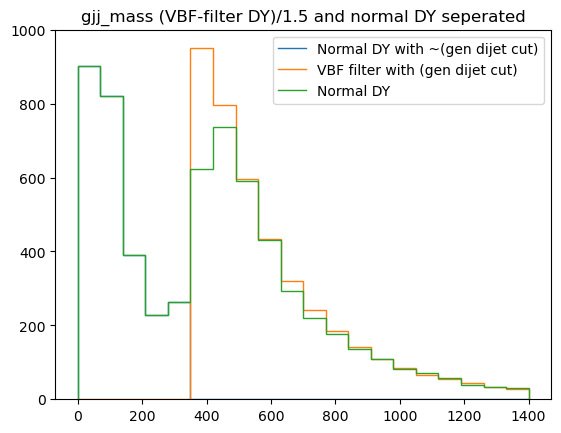

<Figure size 640x480 with 0 Axes>

In [63]:
"""
dijet mass plot of vbf filtered DY vs normal DY 
"""
binning_map = {
    "gjj_mass" : [0, 2*700, 21],
    # "jj_mass" : [250, 2_000, 21],
    "jj_mass" : [0, 700, 21],
}

factor = 1.5
for var in ["gjj_mass"]:
    binning = np.linspace(*binning_map[var])
    hist_VbfFilter_dyIncl, edges = np.histogram(df_dyIncl[var], bins=binning, weights=filter_plot_dyIncl_wgt)
    hist_VbfFilter_dyVbfFilter, _= np.histogram(df_dyVBFfilter[var], bins=binning, weights=filter_plot_dyVBFfilter_wgt/factor)
    hist_dyIncl, _ = np.histogram(df_dyIncl[var], bins=binning, weights=normal_plot_wgt)
    plt.stairs(hist_VbfFilter_dyIncl, edges, label = "Normal DY with ~(gen dijet cut)")
    plt.stairs(hist_VbfFilter_dyVbfFilter, edges, label = "VBF filter with (gen dijet cut)")
    plt.stairs(hist_dyIncl, edges, label = "Normal DY")
    plt.ylim(0, 1_000)
    plt.legend(loc="upper right")
    plt.title(f"{var} (VBF-filter DY)/{factor} and normal DY seperated")
    plt.savefig(f"./quick_plots/{var}_separate.pdf")
    plt.show()
    plt.clf()

In [28]:
70.1*5

350.5

In [62]:
np.linspace(*[0, 2*700, 21])

array([   0.,   70.,  140.,  210.,  280.,  350.,  420.,  490.,  560.,
        630.,  700.,  770.,  840.,  910.,  980., 1050., 1120., 1190.,
       1260., 1330., 1400.])